# HOMEWORK 2 (CUMUL) - Network Measurement and Data Analysis Lab

*Stefano Maxenti, 10526141, 970133*

### Index

[LIBRARIES AND FUNCTIONS](#libraries_and_functions)

[CURL](#cumulative_trace_curl)

[FIREFOX](#cumulative_trace_firefox)

[CONCLUSIONS](#conclusions)

## Libraries and functions
<a id='libraries_and_functions'></a>

In this first section, I import various needed libraries and define some useful functions which are used in the code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join, splitext
import statistics
from cyberpandas import IPArray, to_ipaddress

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import  classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from scipy.interpolate import interp1d
import joblib # this library is useful to save objects to the drive and to load them again

In [2]:
# It encodes categorical labels to numerical values and returns the dataset with only values as well
def label_encoding(dataset):
    le = LabelEncoder();
    X = dataset.dropna();
    Y = le.fit_transform(X['website']);
    X = X.drop(['website'],axis=1);
    return X, Y, le

# It normalizes values using a standard scaler: X = (X-mean)/std. It returns the scaler as well
def normalization(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, scaler

In [15]:
# This is the requested K-NN classifier. Plot and verbose are flags used to determine how much output to show
def knn_classifier(X_train, Y_train, X_test, Y_test, plot=False, verbose=False):
    accuracy_list = []
    knn_list = []
    for k in range(1, 11):
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(X_train, Y_train)
        accuracy = knn.score(X_test, Y_test)
        accuracy_list.append(accuracy)
        knn_list.append(knn)
        if (verbose):
            print("k = ", k , ": accuracy = ", accuracy)
    best_accuracy = max(accuracy_list)
    k = accuracy_list.index(max(accuracy_list))+1
    if (verbose):
        print("Best result is ", best_accuracy, 
          " obtained with k = ", k)
    if (plot):
        plt.xticks(np.arange(1,11,1))
        plt.plot(np.arange(1,11,1), accuracy_list)
        plt.ylabel('Accuracy')
        plt.xlabel('K')
        plt.grid(visible=True);
    return knn_list[k-1]

In [4]:
# A very basic random forest classifier
def random_forest_classifier(X_train, Y_train, X_test, Y_test, verbose=False):
    rf = RandomForestClassifier()
    rf.fit(X_train, Y_train)
    rf_accuracy = rf.score(X_test, Y_test)
    if (verbose):
        print("Accuracy: ", rf_accuracy)
    return rf

In [5]:
# A very basic multi-layer-perceptron for deep learning
# In order to keep the training and testing codes of models as consistent as possible, 
# I keep only the deep learning implementation from Sklearn and not the more powerful one from Keras/Tensorflow.
# Results between SK and TF prove to be similar, even though in Sklearn it is not possible to apply 
# advanced regularization technique such as dropout, Glorot initialization and reduction of learning rate on plateau.
def multi_layer_perceptron_classifier(X_train, Y_train, X_test, Y_test, verbose=False):
    mlp = MLPClassifier(random_state=1, solver='adam',  # adam optimizer for the gradient descent
                        learning_rate_init=1e-4, # initial learning rate
                        hidden_layer_sizes=(128, 64), # two fully connected hidden layers with 128 and 64 neurons each
                        max_iter=1000, # maximum number of epochs to train
                        early_stopping=True, # to avoid overfitting, I keep 10% of the training data as validation set
                        n_iter_no_change=30, # validation loss is monitored for 30 epochs before stopping
                        batch_size=8) # the gradient is updated every 8 samples.
    mlp.fit(X_train, Y_train)
    mlp_accuracy = mlp.score(X_test, Y_test)
    if (verbose):
        print("FINAL ACCURACY: ", mlp_accuracy)
    return mlp

In [6]:
# A Support Vector Machine classifier, built with the same c and gamma values as the suggested paper.
def svm_classifier(X_train, Y_train, X_test, Y_test, verbose=False):
    gamma = [2**-3, 2**-1, 2, 2**3]
    c = [2**11, 2**13, 2**15, 2**17]
    svm_list = []
    accuracy_list = [] 
    i = 0
    for c_ in c:
        for g in gamma:
            svm = SVC(gamma=g, C=c_)
            svm.fit(X_train, Y_train)
            svm_list.append(svm)
            svm_accuracy = svm.score(X_test, Y_test)
            accuracy_list.append(svm_accuracy)
            if (verbose):
                print("Accuracy with c =", c_, "and gamma =", g,":", svm_accuracy)
            i += 1
    best_accuracy = max(accuracy_list)
    k = accuracy_list.index(max(accuracy_list))
    best_model = svm_list[k]
    if (verbose):
        print('Best accuracy ', best_accuracy, 'with C = ', best_model.get_params()['C'], 'and gamma = ', best_model.get_params()['gamma'])
    return best_model

In [7]:
# A generic function to test the accuracy and to plot the confusion matrix
def model_test(model, X_test, Y_test):
    model_predict = model.predict(X_test)
    model_report = classification_report(Y_test,model_predict,target_names=le.inverse_transform(np.arange(len(websites))),digits=3,output_dict=True, zero_division=0)
    fold_accuracy = model_report['accuracy']
    print("On the test set: accuracy =", fold_accuracy)
    fig, ax = plt.subplots(figsize=(8, 8));
    ConfusionMatrixDisplay.from_predictions(model_predict, Y_test, xticks_rotation=-90, ax=ax, display_labels=le.inverse_transform(np.arange(len(websites))));

In [8]:
def import_csv_cumul(path, M=20):
    tcpdumpfiles = [f for f in listdir(path) if (isfile(join(path, f)) and splitext(join(path,f))[-1] == '.csv')]
    websites = np.unique([f.split('-')[0] for f in tcpdumpfiles])

    dataset = pd.DataFrame()
    print('Processing file...')
    i = 0
    l = len(tcpdumpfiles)
    old_percent = 0
    dicts = []
    for f in tcpdumpfiles:
        try:
            ### these lines provide a quick indication on the importing progress
            percent = int(100*i/l)
            if (percent % 5 == 0 and percent != old_percent):
                print("{0:.0%}".format(percent/100), end= " ")
                old_percent = percent
            i += 1
            ###
            df = pd.read_csv(join(path,f))
            df = df[df['tcp.len'] > 0] # to exclude ACKs
            # np.where(condition, if_true, if_false)
            df['frame.len'] = np.where(to_ipaddress(df['ip.src']).is_private, -df['frame.len'], df['frame.len'])
            row = (df['frame.len'].cumsum()).reset_index(drop=True) # these points are C(1)=p1, C(2)=p1+p2, etc.
            row_len = len(row)

            ###### code taken from https://stackoverflow.com/a/51515357 to sample equidistant points on the interpolant line
            x = np.arange(0, row_len ,1)
            y = row.values
            # this calculates partial cumulative distances between points
            distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
            distance = distance/distance[-1] # normalize values between 0 and 1

            fy = interp1d( distance, y )

            alpha = np.linspace(0, 1, M)
            y_regular = fy(alpha)
            ###### end stackoverflow code
            array_np2 = []
            array_np2.append(y_regular) # it now becomes a row
            row_df = pd.DataFrame.from_dict(array_np2)
            row_df['website'] = f.split('-')[0]
            dataset = dataset.append(row_df)
        except:
            print(f, " was not added to the dataset. Probably corrupted.")
            
    dataset = dataset.reset_index(drop=True)
    return dataset

## Cumulative trace - curl

<a id='cumulative_trace_curl'></a>

In [ ]:
#!wget "https://polimi365-my.sharepoint.com/:u:/g/personal/10526141_polimi_it/ESh0NZOxC0dIpDwOWonGPDEB2kKhmdznvfuSADRS7_kdxA?download=1" -O "input/CSV_curl.zip"
#!unzip "input/CSV_curl.zip" -d "input/"

In [ ]:
#dataset = import_csv_cumul('input/CSV_curl', M=20)
#websites = np.unique(dataset['website'])
#dataset.to_csv('input/DS_cumul_curl.csv', index=False)

In [16]:
# To load...
dataset = pd.read_csv('input/DS_cumul_curl.csv')
websites = np.unique(dataset['website'])
dataset

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,website
0,-583.0,33454.126852,69055.284525,104656.443532,140257.602299,175858.762713,211459.923312,247061.083993,282662.244636,318263.405315,...,3.894657e+05,4.250669e+05,4.606680e+05,4.962692e+05,5.318704e+05,5.674715e+05,6.030727e+05,6.386739e+05,674081.0,indiatimes.com
1,-583.0,96265.541389,194608.121523,292950.702265,391293.284472,489635.867060,587978.448755,686321.030900,784663.609136,883006.190693,...,1.079691e+06,1.178034e+06,1.276377e+06,1.374719e+06,1.473062e+06,1.571404e+06,1.669747e+06,1.768089e+06,1866238.0,nytimes.com
2,-583.0,40647.141727,85787.355185,130927.568948,176067.784292,221208.000624,266348.217135,311488.432207,356628.647745,401768.864091,...,4.920493e+05,5.371895e+05,5.823297e+05,6.274699e+05,6.726102e+05,7.177504e+05,7.628906e+05,8.080308e+05,852811.0,finance.yahoo.com
3,-583.0,95976.437221,194179.913878,292383.388750,390586.865445,488790.341010,586993.818006,685197.296054,783400.772382,881604.249992,...,1.078011e+06,1.176215e+06,1.274418e+06,1.372622e+06,1.470825e+06,1.569029e+06,1.667232e+06,1.765436e+06,1863459.0,dailymail.co.uk
4,-583.0,33594.232985,69335.497088,105076.762262,140818.028158,176559.293911,212300.559884,248041.826044,283783.091773,319524.358093,...,3.910069e+05,4.267482e+05,4.624894e+05,4.982307e+05,5.339720e+05,5.697132e+05,6.054545e+05,6.411957e+05,676743.0,indiatimes.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8919,-571.0,1785.266059,3254.488808,4811.747741,7168.014083,9524.280167,11880.546589,14236.813010,16593.078935,18949.345324,...,2.366188e+04,2.601814e+04,2.837441e+04,3.073068e+04,3.308694e+04,3.544321e+04,3.779948e+04,4.015574e+04,42342.0,msn.com
8920,-583.0,22908.411741,50529.890672,78151.369757,105772.849433,133394.328769,161015.806945,188637.287166,216258.765569,243880.242768,...,2.991232e+05,3.267447e+05,3.543661e+05,3.819876e+05,4.096091e+05,4.372306e+05,4.648521e+05,4.924735e+05,519735.0,news.yahoo.com
8921,-583.0,87090.697337,176258.434220,265426.175649,354593.915346,443761.655704,532929.394981,622097.134136,711264.872912,800432.611103,...,9.787681e+05,1.067936e+06,1.157104e+06,1.246271e+06,1.335439e+06,1.424607e+06,1.513775e+06,1.602942e+06,1691916.0,nytimes.com
8922,-583.0,88896.384949,180019.806342,271143.229528,362266.654911,453390.080286,544513.505444,635636.930631,726760.355688,817883.778556,...,1.000131e+06,1.091254e+06,1.182377e+06,1.273501e+06,1.364624e+06,1.455748e+06,1.546871e+06,1.637995e+06,1728938.0,dailymail.co.uk


In [17]:
X, Y, le = label_encoding(dataset)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
X_train, scaler = normalization(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, "output_models/scaler_c2")

['output_models/scaler_c2']

k =  1 : accuracy =  0.9645257654966393
k =  2 : accuracy =  0.9645257654966393
k =  3 : accuracy =  0.957057505601195
k =  4 : accuracy =  0.9585511575802838
k =  5 : accuracy =  0.9514563106796117
k =  6 : accuracy =  0.9518297236743839
k =  7 : accuracy =  0.9495892457057505
k =  8 : accuracy =  0.9518297236743839
k =  9 : accuracy =  0.9507094846900672
k =  10 : accuracy =  0.9525765496639284
Best result is  0.9645257654966393  obtained with k =  1
On the test set: accuracy = 0.9645257654966393


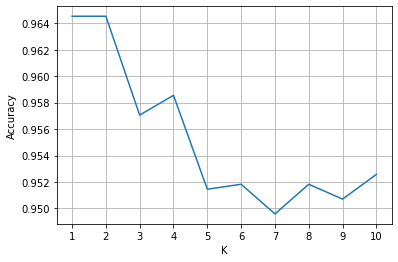

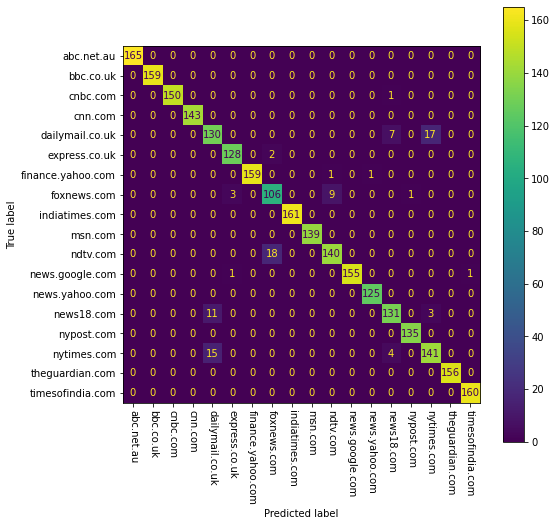

In [18]:
#knn_c2 = joblib.load('output_models/knn_c2.sav')
knn_c2 = knn_classifier(X_train, Y_train, X_test, Y_test, plot=True, verbose=True)
#joblib.dump(knn_c2, "output_models/knn_c2.sav")
model_test(knn_c2, X_test, Y_test)

On the test set: accuracy = 0.9372666168782674


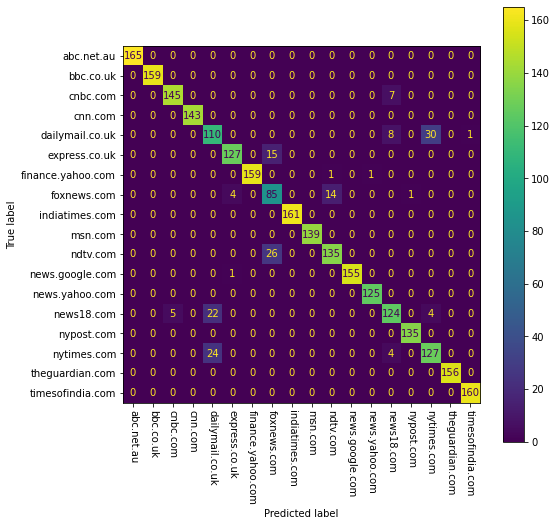

In [12]:
#rf_c2 = joblib.load('output_models/rf_c2.sav')
rf_c2 = random_forest_classifier(X_train, Y_train, X_test, Y_test)
#joblib.dump(rf_c2, "output_models/rf_c2.sav")
model_test(rf_c2, X_test, Y_test)

On the test set: accuracy = 0.8943241224794622


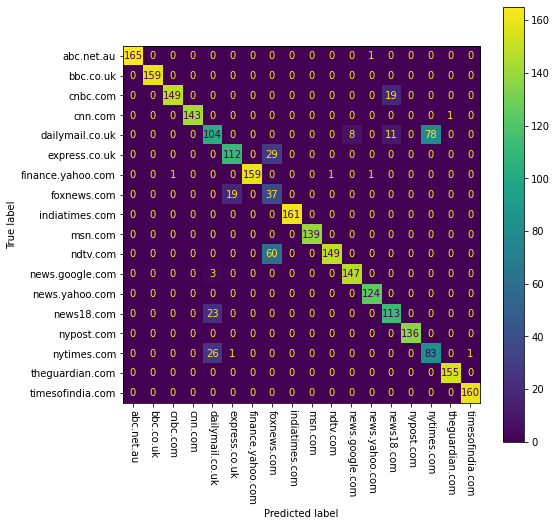

In [13]:
#mlp_c2 = joblib.load("output_models/mlp_c2.sav")
mlp_c2 = multi_layer_perceptron_classifier(X_train, Y_train, X_test, Y_test)
#joblib.dump(mlp_c2, "output_models/mlp_c2.sav")
model_test(mlp_c2, X_test, Y_test)

Accuracy with c = 2048 and gamma = 0.125 : 0.9469753547423451
Accuracy with c = 2048 and gamma = 0.5 : 0.9574309185959672
Accuracy with c = 2048 and gamma = 2 : 0.9675130694548171
Accuracy with c = 2048 and gamma = 8 : 0.9779686333084391
Accuracy with c = 8192 and gamma = 0.125 : 0.955563853622106
Accuracy with c = 8192 and gamma = 0.5 : 0.9690067214339059
Accuracy with c = 8192 and gamma = 2 : 0.9768483943241225
Accuracy with c = 8192 and gamma = 8 : 0.9805825242718447
Accuracy with c = 32768 and gamma = 0.125 : 0.9742345033607169
Accuracy with c = 32768 and gamma = 0.5 : 0.9749813293502614
Accuracy with c = 32768 and gamma = 2 : 0.9783420463032113
Accuracy with c = 32768 and gamma = 8 : 0.9831964152352501
Accuracy with c = 131072 and gamma = 0.125 : 0.9753547423450336
Accuracy with c = 131072 and gamma = 0.5 : 0.9768483943241225
Accuracy with c = 131072 and gamma = 2 : 0.9828230022404779
Accuracy with c = 131072 and gamma = 8 : 0.9839432412247946
Best accuracy  0.9839432412247946 wit

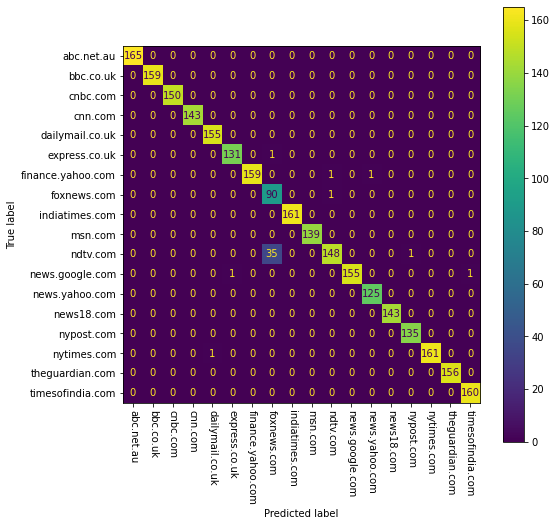

In [14]:
#svm_c2 = joblib.load("output_models/svm_c2.sav")
svm_c2 = svm_classifier(X_train, Y_train, X_test, Y_test, verbose=True)
#joblib.dump(svm_c2, "output_models/svm_c2.sav")
model_test(svm_c2, X_test, Y_test)

Now we move to testing in different days. Let's load the model and, if necessary, download the complete CSVs before pre-processing.

In [10]:
knn_c2 = joblib.load('output_models/knn_c2.sav')
rf_c2 = joblib.load('output_models/rf_c2.sav')
mlp_c2 = joblib.load('output_models/mlp_c2.sav')
svm_c2 = joblib.load('output_models/svm_c2.sav')

scaler = joblib.load('output_models/scaler_c2')

In [ ]:
#!wget "https://polimi365-my.sharepoint.com/:u:/g/personal/10526141_polimi_it/EcstXWzLgIlPokDeauhr8-0BHjgNxKav7jzx0oDqiA6f-Q?download=1" -O "TEST/curl.zip"
#!unzip "TEST/curl.zip" -d "TEST/"




K-NN:  On the test set: accuracy = 0.9462962962962963
RF:    On the test set: accuracy = 0.9388888888888889
MLP:   On the test set: accuracy = 0.8981481481481481
SVM:   On the test set: accuracy = 0.9555555555555556


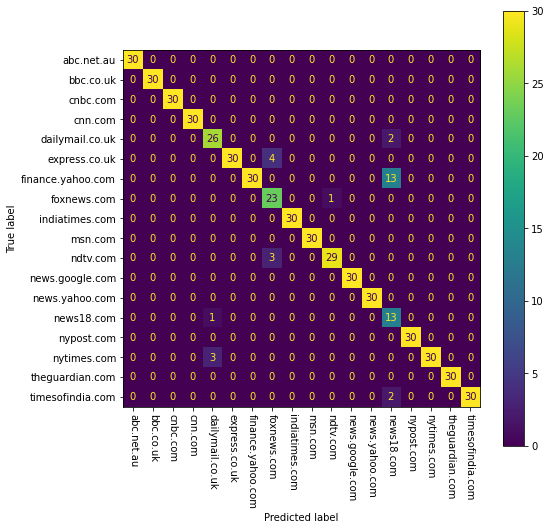

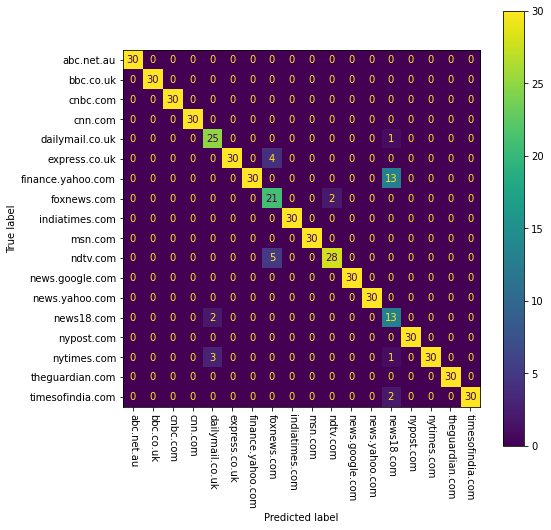

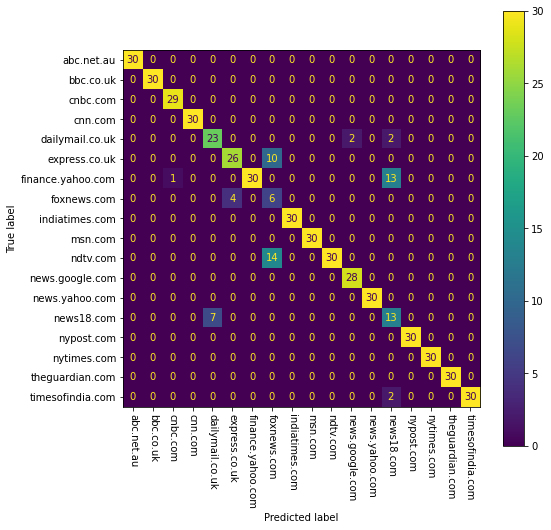

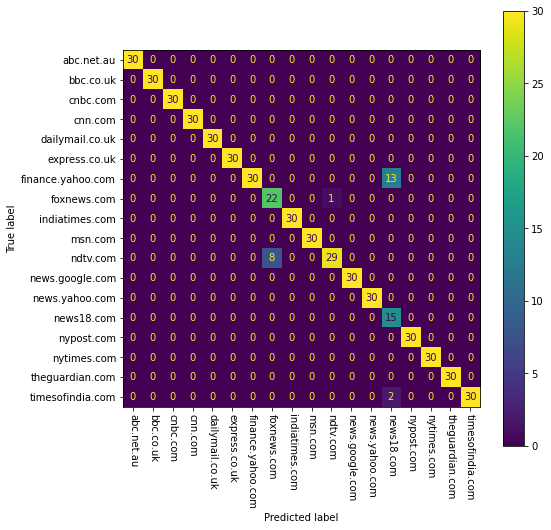

In [11]:
# 1 day later
#dataset = import_csv_cumul('TEST/curl/1DAY')
#dataset.to_csv('TEST/test_cumul_curl_1day.csv', index=False)
dataset = pd.read_csv('TEST/test_cumul_curl_1day.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_c2, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_c2, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_c2, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_c2, X_norm, Y)




K-NN:  On the test set: accuracy = 0.875
RF:    On the test set: accuracy = 0.8373015873015873
MLP:   On the test set: accuracy = 0.8095238095238095
SVM:   On the test set: accuracy = 0.871031746031746


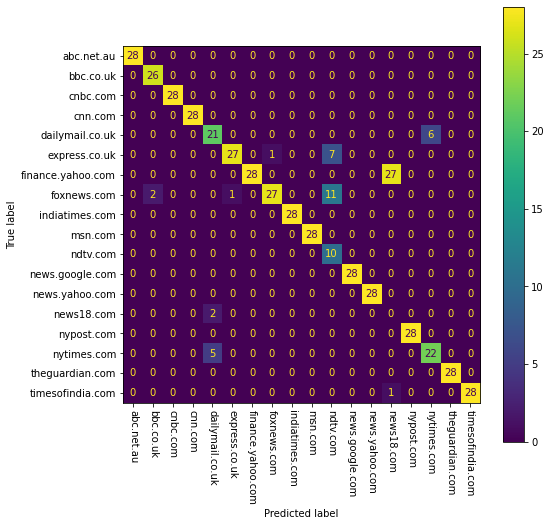

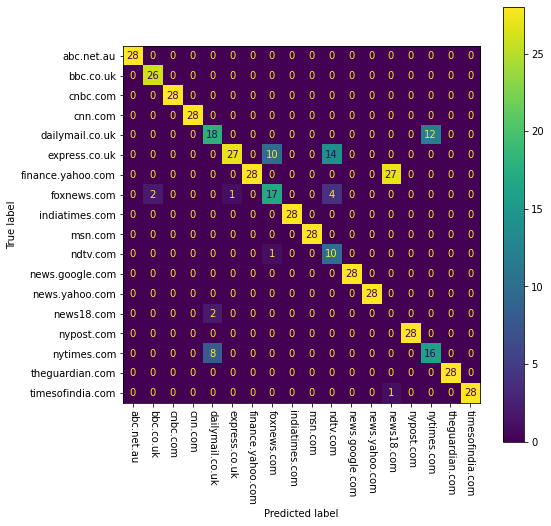

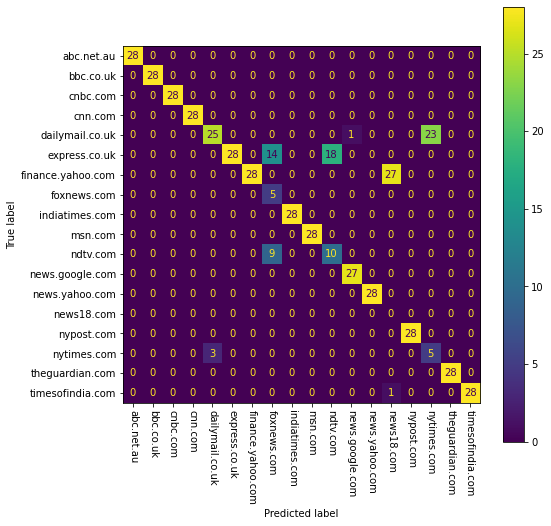

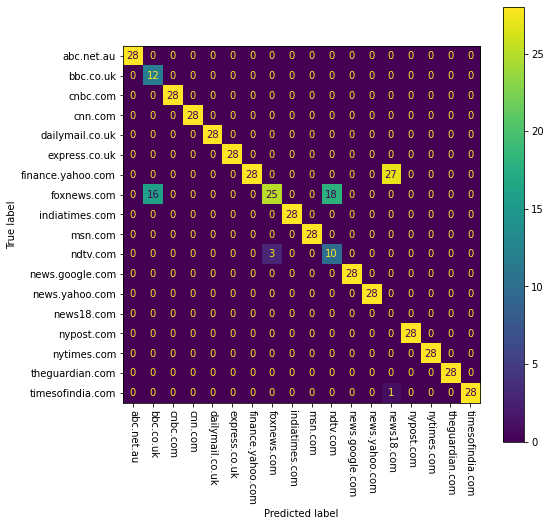

In [12]:
# 3 days later
#dataset = import_csv_cumul('TEST/curl/3DAYS')
#dataset.to_csv('TEST/test_cumul_curl_3days.csv', index=False)
dataset = pd.read_csv('TEST/test_cumul_curl_3days.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_c2, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_c2, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_c2, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_c2, X_norm, Y)




K-NN:  On the test set: accuracy = 0.8461538461538461
RF:    On the test set: accuracy = 0.8311965811965812
MLP:   On the test set: accuracy = 0.8311965811965812
SVM:   On the test set: accuracy = 0.8675213675213675


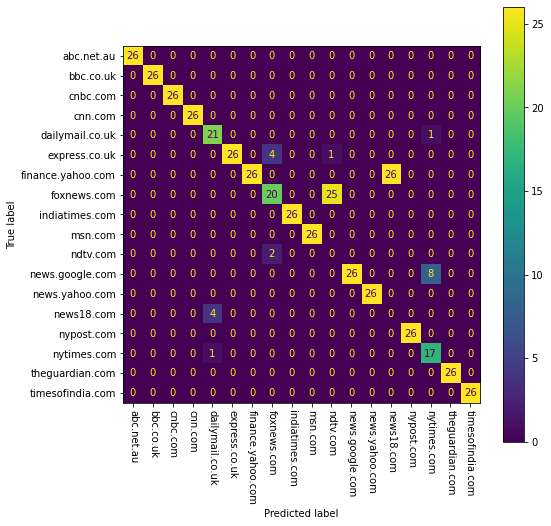

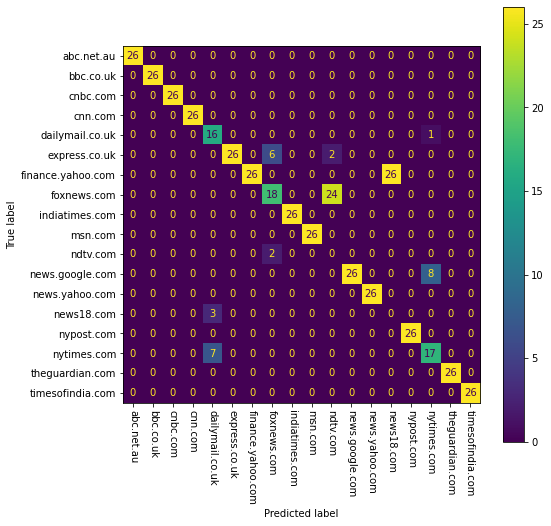

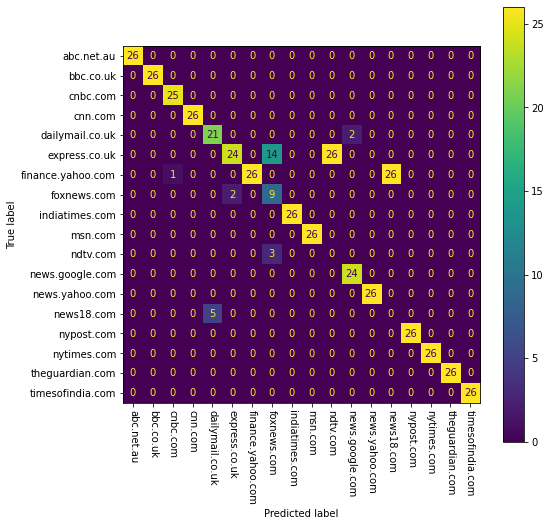

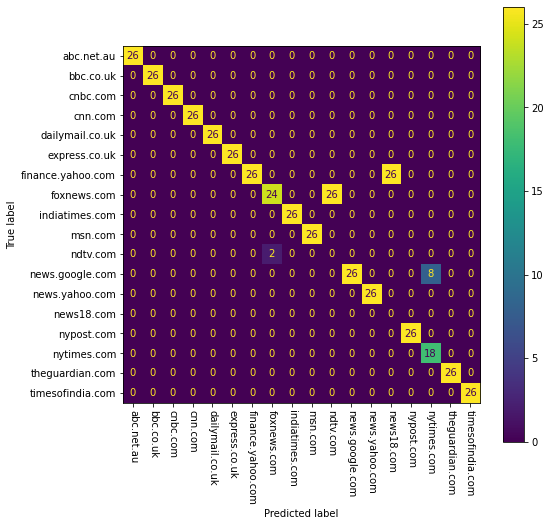

In [13]:
# 7 days later
#dataset = import_csv_cumul('TEST/curl/7DAYS')
#dataset.to_csv('TEST/test_cumul_curl_7days.csv', index=False)
dataset = pd.read_csv('TEST/test_cumul_curl_7days.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_c2, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_c2, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_c2, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_c2, X_norm, Y)

## Cumulative trace - firefox

<a id='cumulative_trace_firefox'></a>

In [ ]:
#!wget "https://polimi365-my.sharepoint.com/:u:/g/personal/10526141_polimi_it/EWis4276qyJDqaTRBAAlhTcB0gA0k1HFDV25gnbM3syAWg?download=1" -O "input/CSV_firefox.zip"
#!unzip "input/CSV_firefox.zip" -d "input/"

In [13]:
#dataset = import_csv_cumul('input/CSV_firefox', M=20)
#websites = np.unique(dataset['website'])
#dataset.to_csv('input/DS_cumul_firefox.csv', index=False)

Processing file...
5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 

In [19]:
# To load...
dataset = pd.read_csv('input/DS_cumul_firefox.csv')
websites = np.unique(dataset['website'])
dataset

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,website
0,-262.0,16853.683086,44049.439275,67819.192450,89742.871610,116938.627332,135724.355780,162920.111978,1.901159e+05,2.167864e+05,...,2.709531e+05,2.939089e+05,3.176126e+05,3.385696e+05,3.643501e+05,3.880459e+05,4.054656e+05,4.326614e+05,450961.0,abc.net.au
1,-262.0,31674.365176,74370.789563,117067.213990,159763.638091,202460.062525,245156.486927,287852.911254,3.305493e+05,3.668097e+05,...,4.215223e+05,4.619367e+05,4.979611e+05,5.375035e+05,5.641822e+05,5.804081e+05,6.155725e+05,6.577089e+05,679609.0,nytimes.com
2,-262.0,56568.644193,125701.362227,194834.080312,263966.798047,321499.368038,384922.078616,449826.766826,5.128235e+05,5.719601e+05,...,7.079375e+05,7.733682e+05,8.366589e+05,9.018336e+05,9.709663e+05,1.040099e+06,1.109232e+06,1.178364e+06,1242423.0,dailymail.co.uk
3,-262.0,58447.222091,134250.575648,210053.928784,282071.275160,357874.628344,423485.881298,479539.100420,5.420756e+05,4.662722e+05,...,3.146655e+05,2.388622e+05,1.681349e+05,1.551116e+05,7.930823e+04,3.504878e+03,-7.229847e+04,-1.481018e+05,-218907.0,news.google.com
4,-262.0,21211.129175,51618.329207,85043.547400,118282.755404,151707.973446,182849.189451,204204.358637,2.240675e+05,2.462586e+05,...,2.848849e+05,3.183101e+05,3.517353e+05,3.851605e+05,4.185858e+05,4.520110e+05,4.749681e+05,4.980452e+05,507710.0,cnn.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,-262.0,3018.009989,2516.004786,5664.005149,6929.998567,10210.008375,12162.011968,11987.988146,1.466202e+04,1.794203e+04,...,1.958801e+04,2.286802e+04,2.614803e+04,2.828604e+04,3.101396e+04,3.325804e+04,3.653805e+04,3.981806e+04,41168.0,dailymail.co.uk
2272,-262.0,57293.113588,133640.347922,209987.582171,277442.793272,333895.788654,384526.870721,460514.101300,5.368613e+05,5.803245e+05,...,6.682048e+05,7.415420e+05,7.889892e+05,8.542004e+05,9.305476e+05,1.004019e+06,1.080366e+06,1.145113e+06,1177816.0,finance.yahoo.com
2273,-571.0,44045.909097,91984.865742,139241.744390,192060.717969,235993.618069,267289.724626,305007.139249,3.547441e+05,4.093791e+05,...,4.886249e+05,5.298977e+05,5.843767e+05,6.390117e+05,6.870826e+05,7.394336e+05,7.929266e+05,8.313334e+05,862886.0,ndtv.com
2274,-571.0,128344.489489,266682.054991,388317.498762,519612.970858,559855.519690,420015.954642,280176.391959,3.697410e+05,5.095805e+05,...,7.892597e+05,9.289132e+05,1.068753e+06,1.208592e+06,1.331324e+06,1.191484e+06,1.051823e+06,1.006191e+06,1138468.0,news.google.com


In [20]:
X, Y, le = label_encoding(dataset)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)
X_train, scaler = normalization(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'output_models/scaler_f2')

['output_models/scaler_f2']

k =  1 : accuracy =  0.7086383601756955
k =  2 : accuracy =  0.7086383601756955
k =  3 : accuracy =  0.705710102489019
k =  4 : accuracy =  0.7042459736456809
k =  5 : accuracy =  0.6998535871156661
k =  6 : accuracy =  0.6925329428989752
k =  7 : accuracy =  0.6866764275256223
k =  8 : accuracy =  0.6896046852122987
k =  9 : accuracy =  0.6822840409956076
k =  10 : accuracy =  0.6837481698389458
Best result is  0.7086383601756955  obtained with k =  1
On the test set: accuracy = 0.7086383601756955


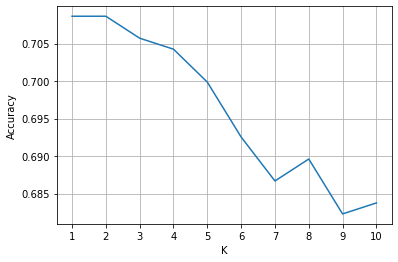

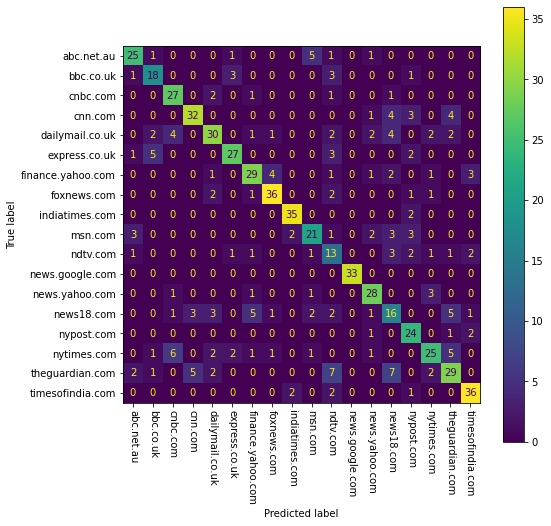

In [21]:
#knn_f2 = joblib.load('output_models/knn_f2.sav')
knn_f2 = knn_classifier(X_train, Y_train, X_test, Y_test, plot=True, verbose=True)
#joblib.dump(knn_f2, "output_models/knn_f2.sav")
model_test(knn_f2, X_test, Y_test)

On the test set: accuracy = 0.7306002928257687


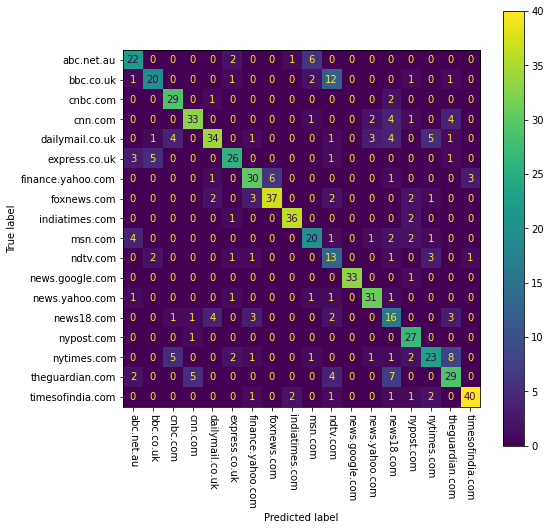

In [15]:
#rf_f2 = joblib.load('output_models/rf_f2.sav')
rf_f2 = random_forest_classifier(X_train, Y_train, X_test, Y_test)
#joblib.dump(rf_f2, "output_models/rf_f2.sav")
model_test(rf_f2, X_test, Y_test)

On the test set: accuracy = 0.5592972181551976


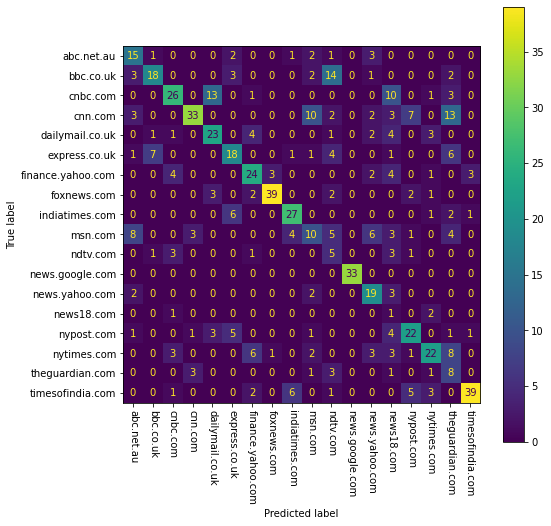

In [25]:
#mlp_f2 = joblib.load("output_models/mlp_f2.sav")
mlp_f2 = multi_layer_perceptron_classifier(X_train, Y_train, X_test, Y_test)
#joblib.dump(mlp_f2, "output_models/mlp_f2.sav")
model_test(mlp_f2, X_test, Y_test)

Accuracy with c = 2048 and gamma = 0.125 : 0.8711566617862372
Accuracy with c = 2048 and gamma = 0.5 : 0.8506588579795022
Accuracy with c = 2048 and gamma = 2 : 0.8330893118594437
Accuracy with c = 2048 and gamma = 8 : 0.8008784773060029
Accuracy with c = 8192 and gamma = 0.125 : 0.8711566617862372
Accuracy with c = 8192 and gamma = 0.5 : 0.849194729136164
Accuracy with c = 8192 and gamma = 2 : 0.8330893118594437
Accuracy with c = 8192 and gamma = 8 : 0.8008784773060029
Accuracy with c = 32768 and gamma = 0.125 : 0.8726207906295754
Accuracy with c = 32768 and gamma = 0.5 : 0.8462664714494875
Accuracy with c = 32768 and gamma = 2 : 0.8330893118594437
Accuracy with c = 32768 and gamma = 8 : 0.8008784773060029
Accuracy with c = 131072 and gamma = 0.125 : 0.8682284040995608
Accuracy with c = 131072 and gamma = 0.5 : 0.8462664714494875
Accuracy with c = 131072 and gamma = 2 : 0.8330893118594437
Accuracy with c = 131072 and gamma = 8 : 0.8008784773060029
Best accuracy  0.8726207906295754 wit

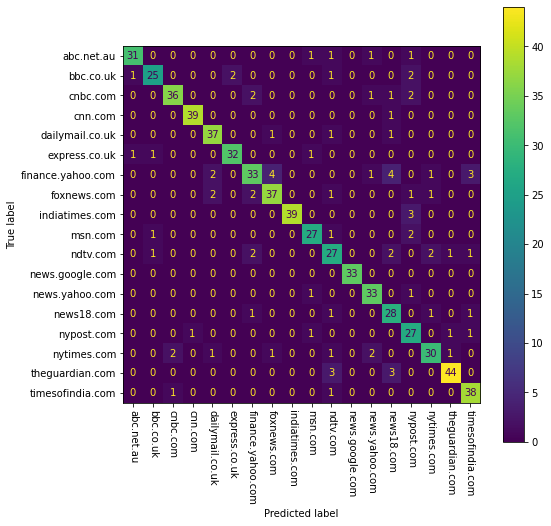

In [26]:
#svm_f2 = joblib.load("output_models/svm_f2.sav")
svm_f2 = svm_classifier(X_train, Y_train, X_test, Y_test, verbose=True)
#joblib.dump(svm_f2, "output_models/svm_f2.sav")
model_test(svm_f2, X_test, Y_test)

Now we move to testing in different days. Let's load the model and, if necessary, download the complete CSVs before pre-processing.

In [9]:
knn_f2 = joblib.load('output_models/knn_f2.sav')
rf_f2 = joblib.load('output_models/rf_f2.sav')
mlp_f2 = joblib.load('output_models/mlp_f2.sav')
svm_f2 = joblib.load('output_models/svm_f2.sav')

scaler = joblib.load('output_models/scaler_f2')

In [ ]:
#!wget "https://polimi365-my.sharepoint.com/:u:/g/personal/10526141_polimi_it/Ed0xg5e-IN9PmcbDB7tkPWoBq24hpAwaD1eEuraBstraGw?download=1" -O "TEST/firefox.zip"
#!unzip "TEST/firefox.zip" -d "TEST/"




K-NN:  On the test set: accuracy = 0.6065259117082533
RF:    On the test set: accuracy = 0.6218809980806143
MLP:   On the test set: accuracy = 0.42610364683301344
SVM:   On the test set: accuracy = 0.7389635316698656


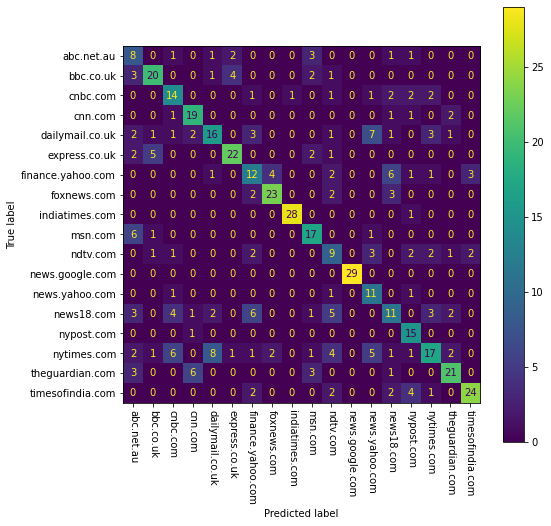

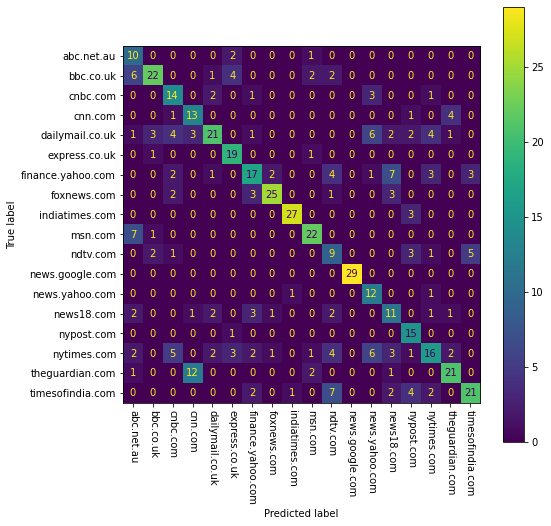

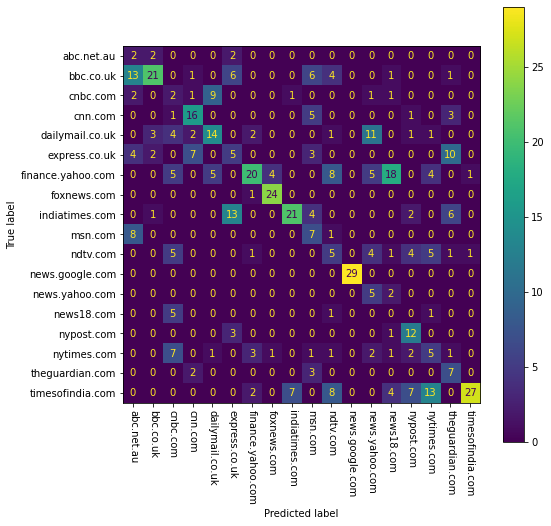

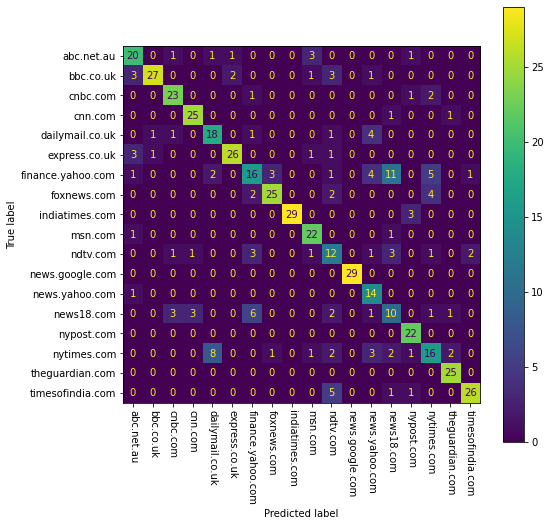

In [19]:
# 1 day later
#dataset = import_csv_cumul('TEST/firefox/1DAY')
#dataset.to_csv('TEST/test_cumul_firefox_1day.csv', index=False)
dataset = pd.read_csv('TEST/test_cumul_firefox_1day.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_f2, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_f2, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_f2, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_f2, X_norm, Y)




K-NN:  On the test set: accuracy = 0.4616858237547893
RF:    On the test set: accuracy = 0.4674329501915709
MLP:   On the test set: accuracy = 0.39272030651340994
SVM:   On the test set: accuracy = 0.48659003831417624


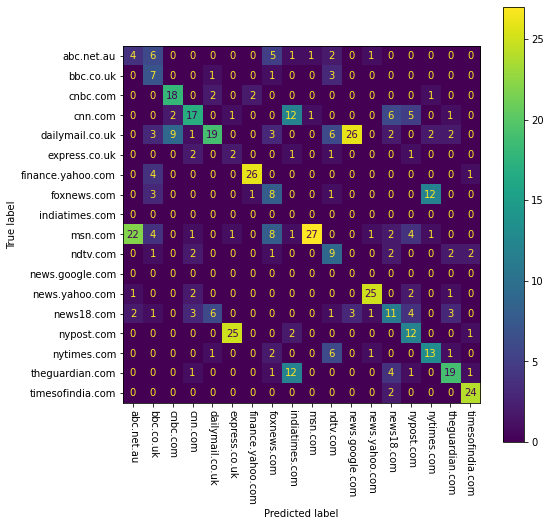

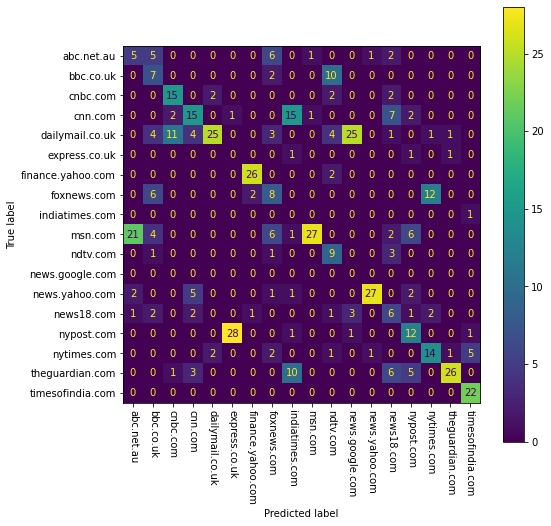

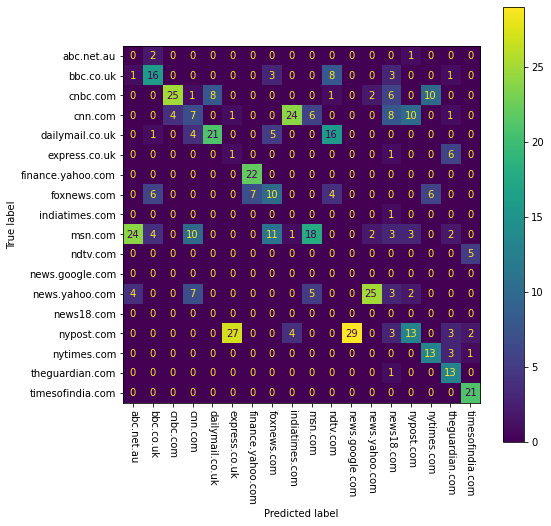

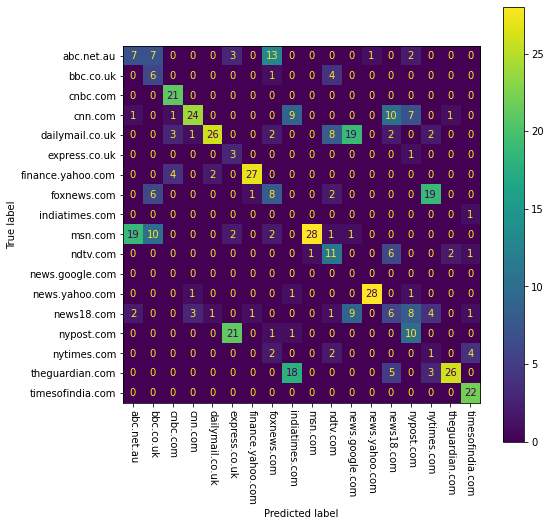

In [20]:
# 3 days later
#dataset = import_csv_cumul('TEST/firefox/3DAYS')
#dataset.to_csv('TEST/test_cumul_firefox_3days.csv', index=False)
dataset = pd.read_csv('TEST/test_cumul_firefox_3days.csv')
websites = np.unique(dataset['website'])

X_norm, Y, le = label_encoding(dataset)
X_norm = scaler.transform(X_norm)

print("\n\n")

print("K-NN: ", end = " ")
model_test(knn_f2, X_norm, Y)
print("RF:   ", end = " ")
model_test(rf_f2, X_norm, Y)
print("MLP:  ", end = " ")
model_test(mlp_f2, X_norm, Y)
print("SVM:  ", end = " ")
model_test(svm_f2, X_norm, Y)

Since accuracy drops a lot, it does not make much sense to test the CUMUL classifiers based on Firefox after 7 days.

Some of the impact may come from the different connection used to perform tests (previous test were done on GARR network in Milan, the 3-DAY dataset was obtained using a residential Eolo connection in my hometown).

However, it is intersting to notice that the drop in performance is much less than with the biflow case.

## Conclusions
<a id='conclusions'></a>

Generically speaking, accuracy some days after decreseas in all scenarios. This makes sense, since websites are frequently updated. However, there is not a huge drop in all curl captures. Curl downloads only the html file (without images and javascripts) and do not connect to external CDNs normally used to provide content. This means that, on the average, the same cumulative trace is extracted in more days.
In addition to that, using a very big dataset (more than 400 captures for website) and on different days allows our classifier to be more robust againt new data.

CUMUL performs well on the Curl trace and worse on the Firefox trace, even though it outperforms biflow after three days, probably due to not depending on interarrival times.
CUMUL's implementation using Firefox trace is cumbersome, because different flows are integrated to provide the trace and order of packets could influence the trace as well.
Differentiating by flows could be possible, but it may lead to wrong results in case most of the content comes from an external CDN, which could be shared between websites. Taking average between flows could be used to consider the various TCP flows separately.